In [1]:
import numpy as np
from tensorflow.keras.utils import Sequence
from pydub import AudioSegment
import scipy
import random
from tensorflow.keras.models import Sequential
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import soundfile as sf
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

/home/atharva/virtualenv/venv/lib/python3.6/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/atharva/virtualenv/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
char_map_str = """
<SPACE> 0
a 1
b 2
c 3
d 4
e 5
f 6
g 7
h 8
i 9
j 10
k 11
l 12
m 13
n 14
o 15
p 16
q 17
r 18
s 19
t 20
u 21
v 22
w 23
x 24
y 25
z 26
' 27
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '

In [3]:
def label_out(inp):
    temp=''
    for c in inp:
        if(c=='/'):
            break
        else:
            temp=temp+c
    return temp

In [4]:
def get_param(Y):
    
    labels = np.zeros((12,))
    new = []
    for label in enumerate(Y):
        
        for c in label:
            if c not in char_map:
                continue
            elif c == "'":
                continue
            elif c == " ":
                ch = 0
            else:
                ch = char_map[c]
                new.append(ch)

    while(len(new) < 12):
        new.append(27)
    labels = np.array(new)

    return labels

In [5]:
char_map

{'<SPACE>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27}

In [17]:
class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path, batch_size=32, dim=(101,198), n_channels=1, n_classes=10, shuffle=True):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim))
        y = []
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

            a = graph_spectrogram(self.image_path + 'speech_commands_v0.01/' +  ID )
            b = np.zeros((101,198))
            if (np.shape(a)!=(101,198)):
                b[:,:a.shape[1]] +=a
                c = b
            else:
                c = a
                
            d, ll = self.__string_from_words(list_IDs_temp,ID)
            e = graph_spectrogram(d)
            f = np.zeros((101,398))
            if (np.shape(e)!=(101,398)):
                f[:,:e.shape[1]] +=e
                X[i,] = f
            else:
                X[i,] = e
            lf = get_param(ll)
            y.append(lf)

        return X, y
            
    def __string_from_words(self, list_IDs_temp, ID):
        
        sound1 = AudioSegment.from_wav(self.image_path + 'speech_commands_v0.01/' +  ID )
        id1 = label_out(ID)
        temp_audio = random.choice(list_IDs_temp)
        if(temp_audio != ID):
            id2 = label_out(temp_audio)
        else:
            id2=id1
        combined_sounds = sound1+ AudioSegment.from_wav(self.image_path + 'speech_commands_v0.01/' + temp_audio)
        label_str = id1 + " " + id2
        print(label_str)
        combined_sounds.export('dump.wav', format="wav")
        return "dump.wav", label_str
        os.remove('dump.wav')

In [18]:
path = '/home/atharva/conversational_robot/assignments/Speech_Recog_Assn/'
os.chdir(path)
os.listdir()

['validation_list.txt',
 '.ipynb_checkpoints',
 'speech_commands_v0.01',
 'dump.wav',
 'example_train.wav',
 'data_generator.ipynb',
 'LICENSE',
 '_background_noise_',
 'demo.ipynb',
 'testing_list.txt',
 'README.md',
 'speech_recog_jupyter.ipynb']

In [19]:
train_list = []
valid_list = []
def listing(file, l):
    crimefile = open(file, 'r')
    for line in crimefile.readlines():
    #     row.append([line])
        for i in line.split("\n"):
            l.append(i)
    for e in l:
        if (e == ''):
            l.remove(e)

listing("testing_list.txt",train_list)
listing("validation_list.txt", valid_list)

In [20]:
labels= []
labels_valid=[]

word_dict = {"bed": 0, "bird":1, "cat":2, "dog":3, "down":4, "eight":5, "five":6,
             "four":7, "go":8,"happy":9,"house":10,"left":11,
             "marvin":12,"nine":13,"no":14,"off":15,"one":16,"on":17,"two":18,
             "right":19,"seven":20,"sheila":21,"stop":22,"three":23,"tree":24,
             "up":25,"wow":26,"yes":27,"zero":28, "six": 29}

def make_labels(ls,file):
    for i in file:
        temp=''
        for c in i:
            if(c=='/'):
                break
            else:
                temp=temp+c
        ls.append(word_dict[temp])
make_labels(labels, train_list)
make_labels(labels_valid, valid_list)

# print(train_list)

In [21]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    noise_inj(wav_file, 0.1)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate , data = wavfile.read(wav_file)
    return rate, data

def noise_inj(audio, noise_factor):      #introducing random noise in the audio file
    sr,data = get_wav_info(audio)
    noise = np.random.randn(len(data)) 
    aug_data=data + noise_factor * noise 
    aug_data = aug_data.astype(type(data[0])) 
    return aug_data

In [22]:
from tensorflow.keras.models import Sequential
# import DataGenerator

# Parameters
params = {'dim': (101,398),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}


# Generators
training_generator = DataGenerator(train_list, labels, path,  **params)

six left


ValueError: could not broadcast input array from shape (101,500) into shape (101,398)

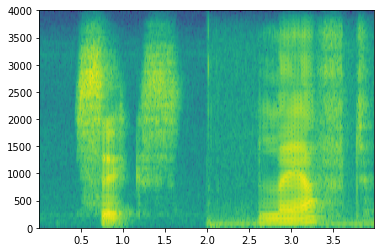

In [23]:
x, y = training_generator.__getitem__(0)
print(y[0])
print(x[0])

In [16]:
print(x.shape)
print(np.shape(y))

(64, 101, 398)
(64, 12)
